Imports and stuff

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import numpy as np
import copy
import splitfolders
from torchviz import make_dot, make_dot_from_trace

Initial Setup

In [2]:
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


Classes

In [3]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

Setup Images

In [5]:
SOURCE = os.path.join(os.getcwd(), "RangeTime")
splitfolders.ratio(SOURCE, output="Learning", seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

TRAIN = os.path.join(os.getcwd(), "Learning", "train")
VALIDATE = os.path.join(os.getcwd(), "Learning", "val")

train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness = 0.1, contrast = 0.1),
    transforms.RandomResizedCrop(256, scale=(0.5, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

validation_transforms  = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=TRAIN, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

validation_dataset = ImageFolder(root=VALIDATE, transform=validation_transforms)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)


Copying files: 1636 files [00:00, 1902.33 files/s]


Neural Network


In [6]:
class_count = len(train_dataset.classes)

# Define the CNN architecture
model = nn.Sequential(
            # Features
            nn.Conv2d(3, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Classifier
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(64 * 6 * 6, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, class_count)).to(device)

optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

Training

In [8]:
def validate(model, loader):
    loss_num = loss_denom = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs.to(device))
            loss_num += loss_fn(outputs, labels.to(device))
            loss_denom += 1

    return loss_num / loss_denom

# Create datasets
BATCH_SIZE = 16

es = EarlyStopping()

epoch = 0
done = False
while epoch < 1000 and not done:
    epoch += 1
    steps = list(enumerate(train_loader))
    pbar = tqdm(steps)
    model.train()
    for i, (x_batch, y_batch) in pbar:
        y_batch_pred = model(x_batch.to(device))
        loss = loss_fn(y_batch_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (i + 1) * len(x_batch)
        if i == len(steps) - 1:
            model.eval()
            vloss = validate(model, validation_loader)
            if es(model, vloss):
                done = True
            pbar.set_description(
                f"Epoch: {epoch}, tloss: {loss}, vloss: {vloss:>7f}, {es.status}"
            )
        else:
            pbar.set_description(f"Epoch: {epoch}, tloss {loss:}")

Epoch: 1, tloss: 1.4557163715362549, vloss: 1.593383, : 100%|██████████| 41/41 [00:34<00:00,  1.19it/s]
Epoch: 2, tloss: 1.2582117319107056, vloss: 1.548124, Improvement found, counter reset to 0: 100%|██████████| 41/41 [00:40<00:00,  1.02it/s]
Epoch: 3, tloss: 1.2031362056732178, vloss: 1.312716, Improvement found, counter reset to 0: 100%|██████████| 41/41 [00:41<00:00,  1.01s/it]
Epoch: 4, tloss: 1.210089921951294, vloss: 1.344402, No improvement in the last 1 epochs: 100%|██████████| 41/41 [00:40<00:00,  1.01it/s]
Epoch: 5, tloss: 1.1542444229125977, vloss: 1.308211, Improvement found, counter reset to 0: 100%|██████████| 41/41 [00:42<00:00,  1.03s/it]
Epoch: 6, tloss: 0.9246810674667358, vloss: 1.198790, Improvement found, counter reset to 0: 100%|██████████| 41/41 [00:40<00:00,  1.02it/s]
Epoch: 7, tloss: 0.9324823617935181, vloss: 1.137063, Improvement found, counter reset to 0: 100%|██████████| 41/41 [00:32<00:00,  1.25it/s]
Epoch: 8, tloss: 0.7768973708152771, vloss: 1.158113,

Validate

In [9]:
# Validation and accuracy calculation
model.eval()
preds = []
targets = []
with torch.no_grad():
    for inputs, labels in validation_loader:
        outputs = model(inputs.to(device))
        _, predictions = torch.max(outputs, 1)
        preds.extend(predictions.cpu().numpy())
        targets.extend(labels.cpu().numpy())

correct = accuracy_score(targets, preds)
print(f"Accuracy: {correct}")

Accuracy: 0.7878787878787878


Visualize Model

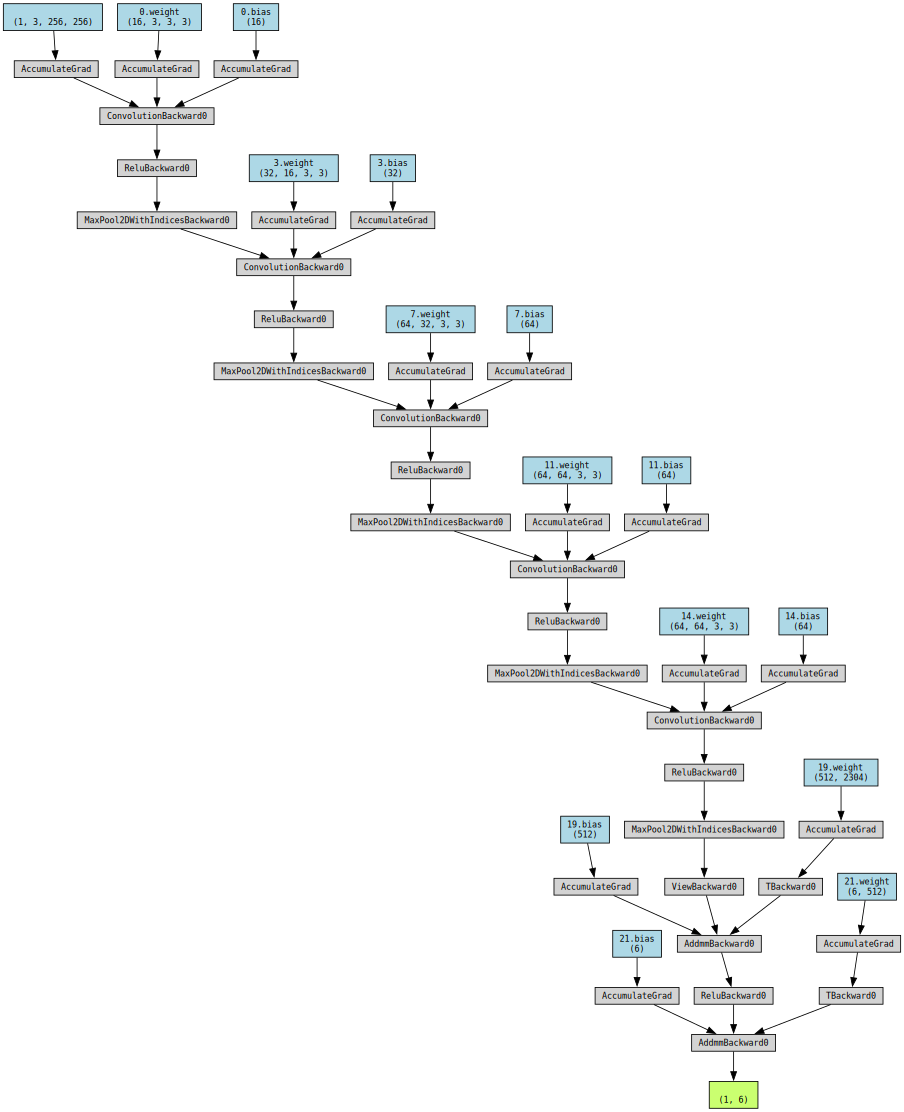

In [10]:
x = torch.randn(1, 3, 256, 256).requires_grad_(True)
y = model(x)
make_dot(y, params=dict(model.named_parameters()))